
# pPXF: Fitting both photometry and spectra

![pPXF](https://www-astro.physics.ox.ac.uk/~cappellari/software/ppxf_logo.svg)

## Description

Usage example for the procedure pPXF originally described in 
[Cappellari & Emsellem (2004)](http://adsabs.harvard.edu/abs/2004PASP..116..138C),
substantially upgraded in 
[Cappellari (2017)](http://adsabs.harvard.edu/abs/2017MNRAS.466..798C) 
and with the inclusion of photometry and linear constraints in 
[Cappellari (2023)](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C).

### MODIFICATION HISTORY

* V1.0.0: Michele Cappellari, Oxford, 29 March 2022: Created
* V1.1.0: Updated for `pPXF` 8.1 using the new `ppxf_util.synthetic_photometry`. MC, Oxford, 10 June 2022
* V1.2.0: Updated for pPXF 8.2. MC, Oxford, 7 September 2022
* V1.3.0: Updated for pPXF 9.0 using the new `sps_util`. MC, Oxford, 19 November 2023
* V1.4.0: Updated for pPXF 9.3. MC, Oxford, 28 June 2024

___

In [1]:
from pathlib import Path
from urllib import request

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib

## Read the observed galaxy spectrum

Read SDSS galaxy spectrum taken from here https://www.sdss4.org/.
The spectrum is *already* log rebinned by the SDSS
pipeline and `log_rebin` should not be used in this case.

In [2]:
ppxf_dir = Path(lib.__file__).parent
file = ppxf_dir / 'spectra' / 'NGC3073_SDSS_DR18.fits'
hdu = fits.open(file)
t = hdu['COADD'].data
redshift = hdu['SPECOBJ'].data['z'].item()       # SDSS redshift estimate

flux = t['flux']
galaxy = flux/np.median(flux)             # Normalize spectrum to avoid numerical issues
ln_lam_gal = t['loglam']*np.log(10)       # Convert lg --> ln
lam_gal = np.exp(ln_lam_gal)              # Wavelength in Angstroms (log sampled)

The SDSS wavelengths are in vacuum, while the MILES ones are in air. For a
rigorous treatment, the SDSS vacuum wavelengths should be converted into air
wavelengths and the spectra should be resampled. To avoid resampling, given
that the wavelength dependence of the correction is very weak, I approximate
it with a constant factor.

In [3]:
lam_gal *= np.median(util.vac_to_air(lam_gal)/lam_gal)

The noise level is chosen to give `Chi^2/DOF=1` without regularization
(`regul=0`). A constant noise is not a bad approximation in the fitted
wavelength range and reduces the noise in the fit.

In [4]:
rms = 0.016
noise = np.full_like(galaxy, rms)  # Assume constant noise per pixel here

## Observed galaxy photometric fluxes

Mean galaxy fluxes in the photometric bands `[FUV, NUV, u, g, r, i, z, J, H, K]`.
They are normalized like the galaxy spectrum

In [5]:
phot_galaxy = np.array([1.23e-16, 6.23e-17, 4.19e-17, 5.67e-17, 3.90e-17, 
                        2.93e-17, 2.30e-17, 1.30e-17, 7.83e-18, 3.49e-18])  # fluxes in erg/cm^2/s/A
phot_noise = np.full_like(phot_galaxy, np.max(phot_galaxy)*0.03)  # 1sigma uncertainties of 3%

## Setup spectral templates


The velocity step was already chosen by the SDSS pipeline and I convert it below to km/s.
I use eq.(8) of [Cappellari (2017)](http://adsabs.harvard.edu/abs/2017MNRAS.466..798C)

In [6]:
c = 299792.458  # speed of light in km/s
d_ln_lam_gal = (ln_lam_gal[-1] - ln_lam_gal[0])/(ln_lam_gal.size - 1)  # Use full lam range for accuracy
velscale = c*d_ln_lam_gal                   # Velocity scale in km/s per pixel (eq.8 of Cappellari 2017)

I convert the instrumental dispersion to Angstroms

In [7]:
dlam_gal = np.gradient(lam_gal)             # Size of every pixel in Angstroms
wdisp = t['wdisp']                          # Instrumental dispersion of every pixel, in pixels units
fwhm_gal = 2.355*wdisp*dlam_gal             # Resolution FWHM of every pixel, in Angstroms

## Setup stellar templates 

pPXF can be used with any set of SPS population templates. However, I am
currently providing (with permission) ready-to-use template files for four
SPS. One can just uncomment one of the four models below. The included files
are only a subset of the SPS that can be produced with the models, and one
should use the relevant software/website to produce different sets of SPS
templates if needed.

1. If you use the [fsps v3.2](https://github.com/cconroy20/fsps) SPS model
   templates, please also cite in your paper 
   [Conroy et al. (2009)](https://ui.adsabs.harvard.edu/abs/2009ApJ...699..486C) and
   [Conroy et al. (2010)](https://ui.adsabs.harvard.edu/abs/2010ApJ...712..833C).

2. If you use the [GALAXEV v2020](http://www.bruzual.org/bc03/) SPS model 
   templates, please also cite in your paper 
   [Bruzual & Charlot (2003)](https://ui.adsabs.harvard.edu/abs/2003MNRAS.344.1000B).

3. If you use the [E-MILES](http://miles.iac.es/) SPS model templates,
   please also cite  in your paper 
   [Vazdekis et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016MNRAS.463.3409V).
   <font color="red">WARNING: The E-MILES models only include SPS with age > 63 Myr and
   are not recommended for highly star forming galaxies.</font>

4. If you use the [X-Shooter Spectral Library (XSL)](http://xsl.u-strasbg.fr/) 
   SPS model templates, please also cite in your paper 
   [Verro et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022A%26A...661A..50V). 
   <font color="red">WARNING: The XSL models only include SPS with age > 50 Myr and
   are not recommended for highly star forming galaxies.</font>

In [8]:
sps_name = 'fsps'
# sps_name = 'galaxev'
# sps_name = 'emiles'
# sps_name = 'xsl'

Read SPS models file from my GitHub if not already in the pPXF package dir. I
am not distributing the templates with pPXF anymore. The SPS model files are
also available [this GitHub page](https://github.com/micappe/ppxf_data).

In [9]:
ppxf_dir = Path(lib.__file__).parent
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename
if not filename.is_file():
    url = "https://raw.githubusercontent.com/micappe/ppxf_data/main/" + basename
    request.urlretrieve(url, filename)

Only the E-MILES and XLS SPS libraries have sufficient resolution beyond 7400 A

In [10]:
if sps_name in ['fsps', 'galaxev']:
    w = lam_gal < 7400
    galaxy = galaxy[w]
    noise = noise[w]
    lam_gal = lam_gal[w]
    fwhm_gal = fwhm_gal[w]

The templates are normalized to the V-band using norm_range. In this way
the weights returned by pPXF represent V-band light fractions of each SSP.

In [11]:
fwhm_gal_dic = {"lam": lam_gal, "fwhm": fwhm_gal}
sps = lib.sps_lib(filename, velscale, fwhm_gal_dic, norm_range=[5070, 5950])

## Setup gas templates

The stellar templates are reshaped below into a 2-dim array with each
spectrum as a column; however, I save the original array dimensions,
which are needed to specify the regularization dimensions

In [12]:
reg_dim = sps.templates.shape[1:]
stars_templates = sps.templates.reshape(sps.templates.shape[0], -1)

Given that both the galaxy spectrum and the templates were normalized to a
median value around unity, a regularization error of about one percent is a
good start. See the pPXF documentation for the keyword `regul`.

In [13]:
regul_err = 0.01

Estimate the wavelength fitted range in the rest frame.

In [14]:
lam_range_gal = np.array([np.min(lam_gal), np.max(lam_gal)])/(1 + redshift)

Construct a set of Gaussian emission line templates. The `emission_lines`
function defines the most common lines, but additional lines can be
included by editing the function in the file ppxf_util.py.

In [15]:
gas_templates, gas_names, line_wave = util.emission_lines(
    sps.ln_lam_temp, lam_range_gal, fwhm_gal_dic)

Emission lines included in gas templates:
['H10' 'H9' 'H8' 'Heps' 'Hdelta' 'Hgamma' 'Hbeta' 'Halpha' '[SII]6716'
 '[SII]6731' '[NeIII]3968' '[NeIII]3869' 'HeII4687' 'HeI5876'
 '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']


Combines the stellar and gaseous templates into a single array. During the
pPXF fit they will be assigned a different kinematic COMPONENT value

In [16]:
templates = np.column_stack([stars_templates, gas_templates])

## Setup photometric templates

In [17]:
bands = ['galex1500', 'galex2500', 'SDSS/u', 'SDSS/g', 'SDSS/r', 'SDSS/i', 'SDSS/z', '2MASS/J', '2MASS/H', '2MASS/K']
phot = util.synthetic_photometry(sps.lam_temp, templates, bands, redshift=redshift, quiet=1)
phot = {"templates": phot.flux, "galaxy": phot_galaxy, "noise": phot_noise, "lam": phot.lam_eff}

Ideally, one would like to have photometry and spectra independently
calibrated and measured within the same aperture. However, the relative
calibration of photometry and spectra is never sufficiently accurate. For
this reason, I am scaling the photometry to match the spectrum, in the
wavelength range in common.

Scale photometry to match the spectrum as in Sec.6.4 of [Cappellari
(2023)](https://ui.adsabs.harvard.edu/abs/10.1093/mnras/stad2597)

First compute synthetic photometry on SDSS galaxy spectrum, which is already
in rest-frame

In [18]:
p2 = util.synthetic_photometry(lam_gal, galaxy, bands, redshift=redshift)

  1 --- Outside template: galex1500
  2 --- Outside template: galex2500
  3 --- Outside template: SDSS/u
  4: SDSS/g
  5: SDSS/r
  6 --- Outside template: SDSS/i
  7 --- Outside template: SDSS/z
  8 --- Outside template: 2MASS/J
  9 --- Outside template: 2MASS/H
 10 --- Outside template: 2MASS/K


Extract the bands that fall inside the galaxy spectrum.
Scale photometry to match the synthetic one from the SDSS spectrum

In [19]:
d = p2.flux[p2.ok]
m = phot_galaxy[p2.ok]    # p2.ok=True if band is in galaxy wavelength range
scale = (d @ m)/(m @ m)   # eq.(34) of Cappellari (2023, MNRAS)
phot_galaxy *= scale
phot_noise *= scale

Compute the photometric templates in the observed bands, excluding the bands
falling outside the range covered by the templates.

In [20]:
p1 = util.synthetic_photometry(sps.lam_temp, templates, bands, redshift=redshift)
phot = {"templates": p1.flux[p1.ok], "lam": p1.lam_eff[p1.ok],
        "galaxy": phot_galaxy[p1.ok], "noise": phot_noise[p1.ok]}

  1: galex1500
  2: galex2500
  3: SDSS/u
  4: SDSS/g
  5: SDSS/r
  6: SDSS/i
  7: SDSS/z
  8: 2MASS/J
  9: 2MASS/H
 10: 2MASS/K


## pPXF input parameters

In [21]:
c = 299792.458
vel = c*np.log(1 + redshift)   # eq.(8) of Cappellari (2017)
start = [vel, 180.]     # (km/s), starting guess for [V, sigma]

I fit two kinematics components, one for the stars and one for the gas.
Assign `component=0` to the stellar templates, `component=1` to the gas.

In [22]:
n_stars = stars_templates.shape[1]
n_gas = len(gas_names)
component = [0]*n_stars + [1]*n_gas
gas_component = np.array(component) > 0  # gas_component=True for gas templates

Fit (V, sig) moments=2 for both the stars and the gas

In [23]:
moments = [2, 2]

Adopt the same starting value for both the stars and the gas components

In [24]:
start = [start, start]

## Start pPXF fit

In [25]:
pp = ppxf(templates, galaxy, noise, velscale, start,
          moments=moments, degree=-1, mdegree=8, lam=lam_gal, lam_temp=sps.lam_temp, 
          component=component, phot=phot, regul=1/regul_err, reg_dim=reg_dim, 
          gas_component=gas_component, reddening=0, gas_names=gas_names)

 Best Fit:       Vel     sigma
 comp.  0:      1063        34
 comp.  1:      1152        42
Stars Attenuation A_V: 0.043
chi2/DOF: 1.046; DOF: 2888; degree = -1; mdegree = 8
Photometry chi2/n_bands: 0.2080; n_bands: 10
method = capfit; Jac calls: 7; Func calls: 100; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 40/404
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1                   H10      0.000     0.033    1152    42
Comp:  1                    H9    0.03412     0.033    1152    42
Comp:  1                    H8     0.2148     0.033    1152    42
Comp:  1                  Heps     0.1674     0.034    1152    42
Comp:  1                Hdelta     0.2888     0.033    1152    42
Comp:  1                Hgamma     0.5914     0.032    1152    42
Comp:  1                 Hbeta      1.183     0.031    1152    42
Com

## Plot fit results for stars, gas and stellar population

In [26]:
light_weights = pp.weights[~gas_component]      # Exclude weights of the gas templates
light_weights = light_weights.reshape(reg_dim)  # Reshape to (n_ages, n_metal)
light_weights /= light_weights.sum()            # Normalize to light fractions

Given that the templates are normalized to the V-band, the `pPXF` weights
represent V-band light fractions and the computed ages and metallicities
below are also light weighted in the V-band.

In [27]:
sps.mean_age_metal(light_weights);
sps.mass_to_light(light_weights, band='SDSS/r', redshift=redshift);

Weighted <lg_age> [yr]: 8.63
Weighted <[M/H]>: -0.187
(M*/L)=1.311 (SDSS/r at z=0.0038)


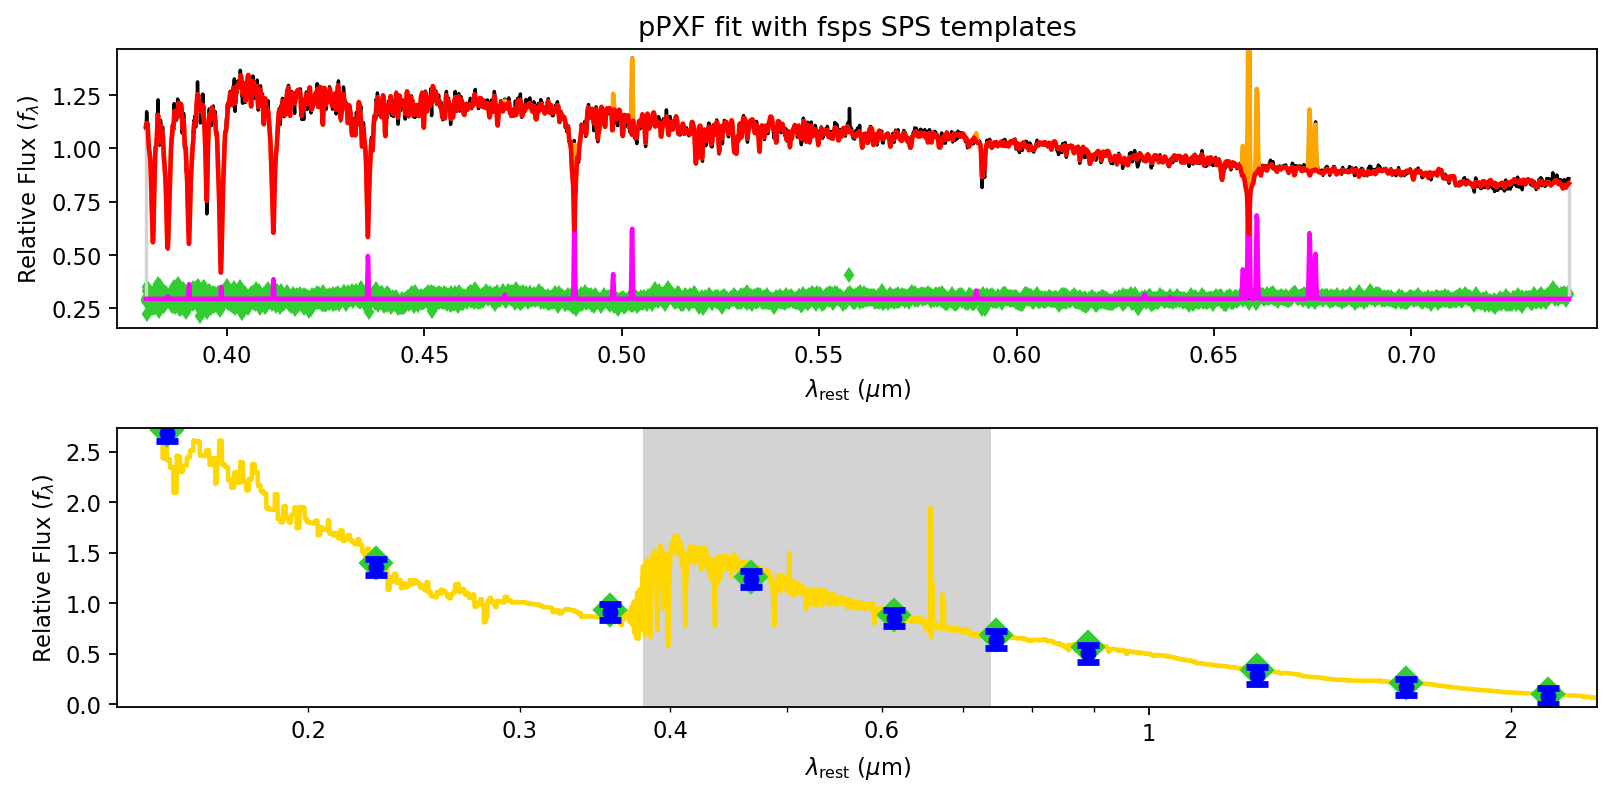

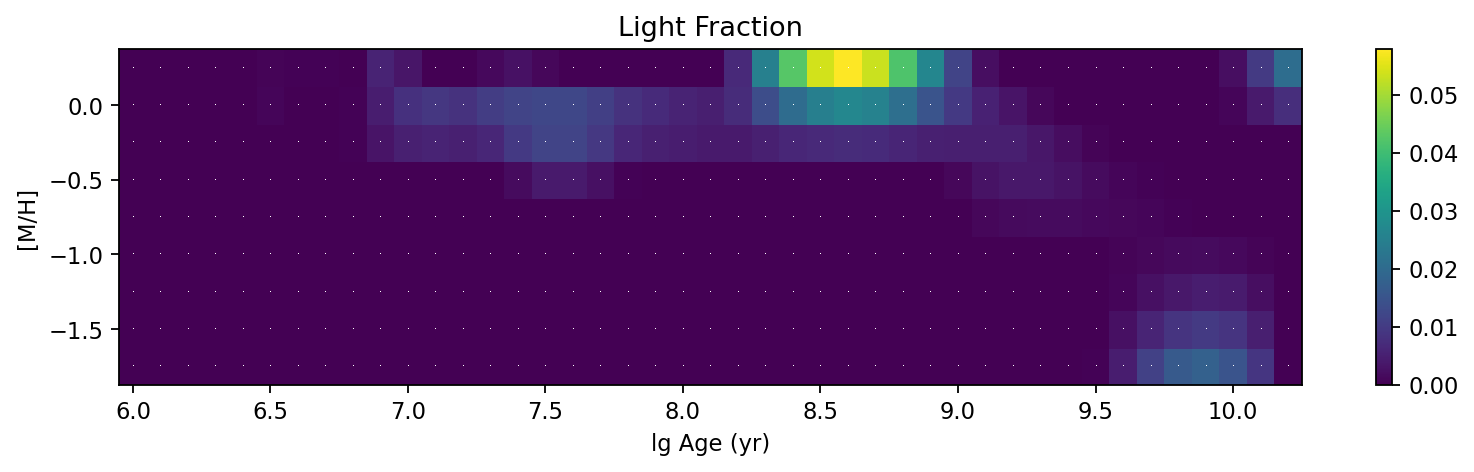

In [28]:
plt.figure(figsize=(10,5))
plt.subplot(211)
pp.plot(phot=False, gas_clip=True)
plt.title(f"pPXF fit with {sps_name} SPS templates")
plt.subplot(212)
pp.plot(spec=False, gas_clip=True)
plt.tight_layout()

plt.figure(figsize=(10,3))
sps.plot(light_weights)
plt.title("Light Fraction")
plt.tight_layout()
plt.pause(5);